# Table of Contents:
## 1. Importing the libraries
## 2. 

# Introduction
## Importing the libraries

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from matplotlib.pyplot import imshow

%matplotlib inline

plt.rcParams['figure.figsize'] = [10,10]

In [3]:
class_dict = pd.read_csv('data/class_dict.csv')
class_dict.head()

,class_index,class,height,width,scale by
0,0,AFRICAN CROWNED CRANE,128,128,1
1,1,AFRICAN FIREFINCH,128,128,1
2,2,ALBATROSS,128,128,1
3,3,ALEXANDRINE PARAKEET,128,128,1
4,4,AMERICAN AVOCET,128,128,1


In [4]:
print(f'There are {class_dict.shape[0]} classes')

There are 310 classes


In [5]:
# read bird dataset
bird_species = pd.read_csv('data/Bird Species.csv')
bird_species.head()

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train


In [6]:
unique_classes = bird_species['labels'].unique().shape[0]
print(f'There are {unique_classes} unique classes')

There are 310 unique classes


In [7]:
bird_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48378 entries, 0 to 48377
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  48378 non-null  object
 1   labels     48378 non-null  object
 2   data set   48378 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


Show example training and test images

(224, 224, 3)


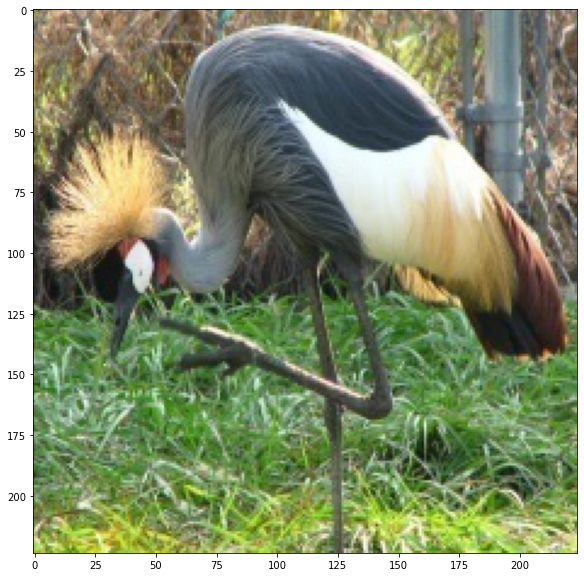

In [8]:
img_path='data/train/AFRICAN CROWNED CRANE/001.jpg'
img=plt.imread(img_path)
print (img.shape)
imshow(img)

(224, 224, 3)


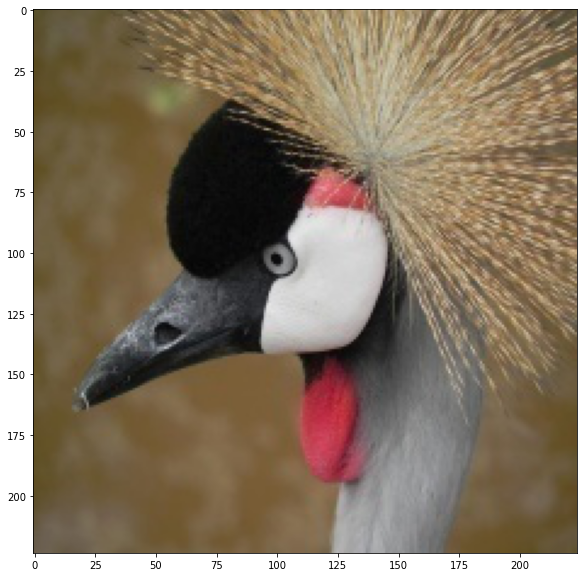

In [9]:
img_path=r'data/test/AFRICAN CROWNED CRANE/1.jpg'
img=plt.imread(img_path)
print (img.shape)
imshow(img)

In [17]:
# check the number of images in each dataset
bird_species['data set'].value_counts()

train    45278
test      1550
valid     1550
Name: data set, dtype: int64

In [ ]:
# add a column to the dataset to store the class index for visualization
bird_species["class_index"] = [
                                class_dict[ class_dict["class"] == 
                                bird_species["labels"][i] ]["class_index"].to_numpy()[0] 
                                for i in range(bird_species.shape[0])
                            ]

In [14]:
# split the dataset into training, test and validation
train_df = bird_species[bird_species['data set'] == 'train']
test_df = bird_species[bird_species['data set'] == 'test']
valid_df = bird_species[bird_species['data set'] == 'valid']


In [15]:
# the shape of the dataset should be the same with value_counts
print(f'The shape of the training dataset is {train_df.shape[0]}')
print(f'The shape of the test dataset is {test_df.shape[0]}')
print(f'The shape of the validation dataset is {valid_df.shape[0]}')

The shape of the training dataset is 45278
The shape of the test dataset is 1550
The shape of the validation dataset is 1550


# EDA

In [16]:
num_images = bird_species.shape[0]
class_names = class_dict["class"].to_list()

In [11]:
# check image min and max pixel for normalization into [0,1]
for i in range(3):
    np.random.seed(i)
    index = np.random.randint(0, num_images)
    filename = os.path.join('data', bird_species['filepaths'][index])

    image = plt.imread(filename)
    print(f'----- Index: {index}')
    print(f'The min pixel value is {image.min()}')
    print(f'The max pixel value is {image.max()}')

----- Index: 2732
The min pixel value is 0
The max pixel value is 255
----- Index: 33003
The min pixel value is 0
The max pixel value is 237
----- Index: 23720
The min pixel value is 0
The max pixel value is 255


As we can see that the images should be normalized. we will do it later in the input pipeline.

### Check data distribution

We should to make sure that there are enough images for each class and check if there's any imbalance class.

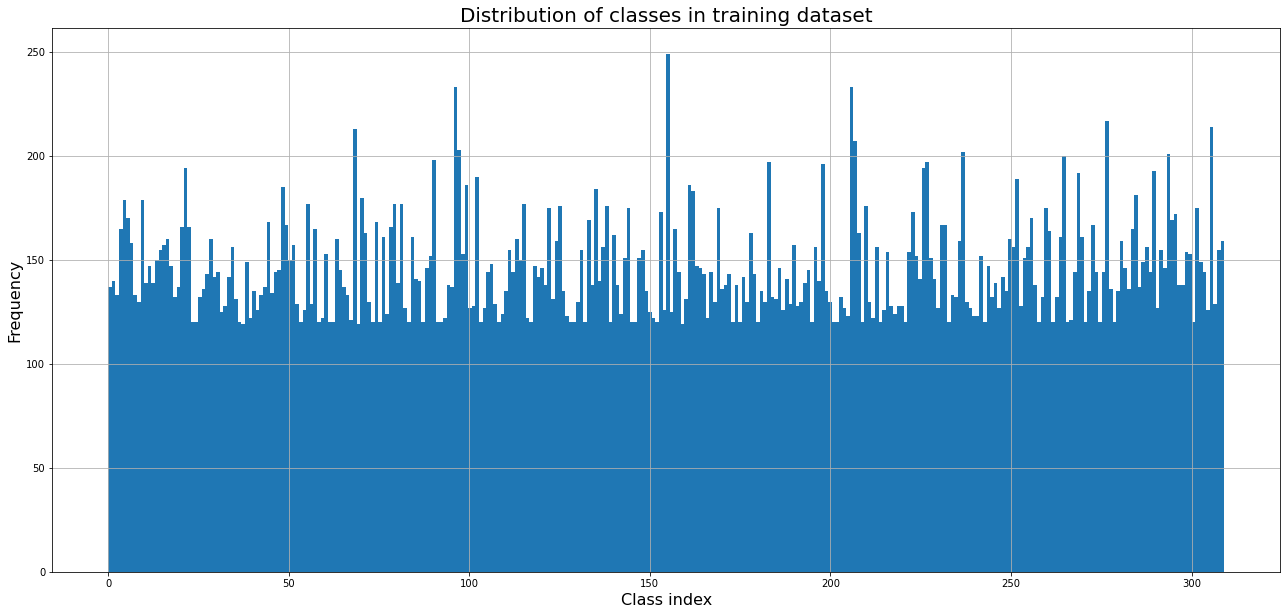

In [17]:
# distribution on train dataset
plt.figure(figsize=(22, 10))
train_df["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in training dataset", size=20)
plt.xlabel("Class index", size=16)
plt.ylabel("Frequency", size=16)
plt.show()

As we can see that some classes on training dataset have less samples than others. this imbalance class could result in a worse model performance on these classes. 

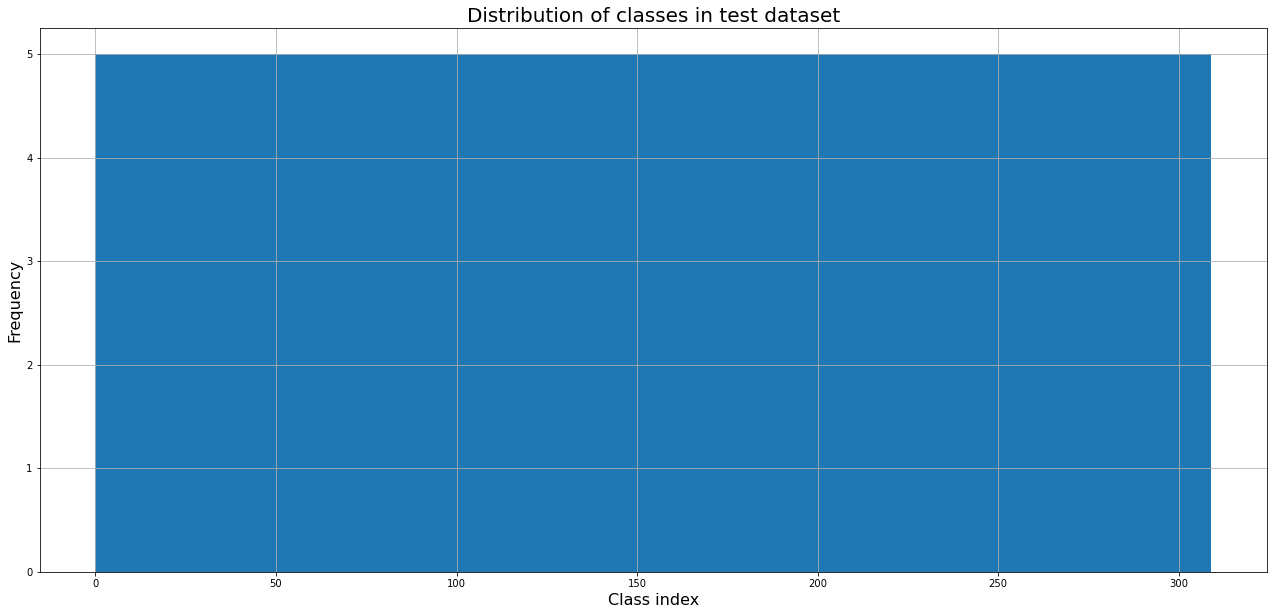

In [18]:
# distribution on test dataset
plt.figure(figsize=(22, 10))
test_df["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in test dataset", size=20)
plt.xlabel("Class index", size=16)
plt.ylabel("Frequency", size=16)
plt.show()

Now, we should transform the data with one-hot encoding to meet the expected format of the model network.

In [19]:
# one-hot encoding the column "class"
train_df = train_df.join(pd.get_dummies(train_df['labels'], prefix='labels'))
test_df = test_df.join(pd.get_dummies(test_df['labels'], prefix='labels'))
valid_df = valid_df.join(pd.get_dummies(valid_df['labels'], prefix='labels'))
train_df.head()


,filepaths,labels,data set,class_index,labels_AFRICAN CROWNED CRANE,labels_AFRICAN FIREFINCH,labels_ALBATROSS,labels_ALEXANDRINE PARAKEET,labels_AMERICAN AVOCET,labels_AMERICAN BITTERN,...,labels_WHITE CHEEKED TURACO,labels_WHITE NECKED RAVEN,labels_WHITE TAILED TROPIC,labels_WHITE THROATED BEE EATER,labels_WILD TURKEY,labels_WILSONS BIRD OF PARADISE,labels_WOOD DUCK,labels_YELLOW BELLIED FLOWERPECKER,labels_YELLOW CACIQUE,labels_YELLOW HEADED BLACKBIRD
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Training with Tensorflow
## Input Pipeline
We will use keras preprocessing layers to augment images. we will also rescale the images (pixel val between 0 and 1).

In [36]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

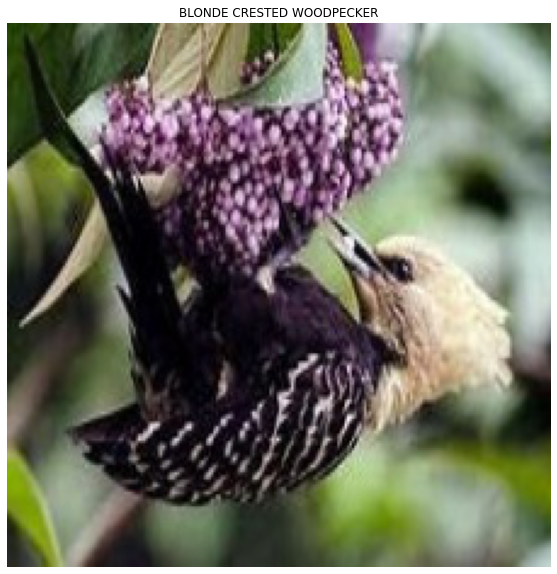

In [30]:
# function to get image from filepath
def get_image(df, folder, index):
    filename = os.path.join(folder, df['filepaths'][index])
    image = plt.imread(filename)
    return image
def show_image(df, folder, index):
    image = get_image(df, folder, index)
    class_name = df["labels"][index]
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)
    plt.show()
index = np.random.randint(0, num_images)
show_image(train_df, 'data', index)

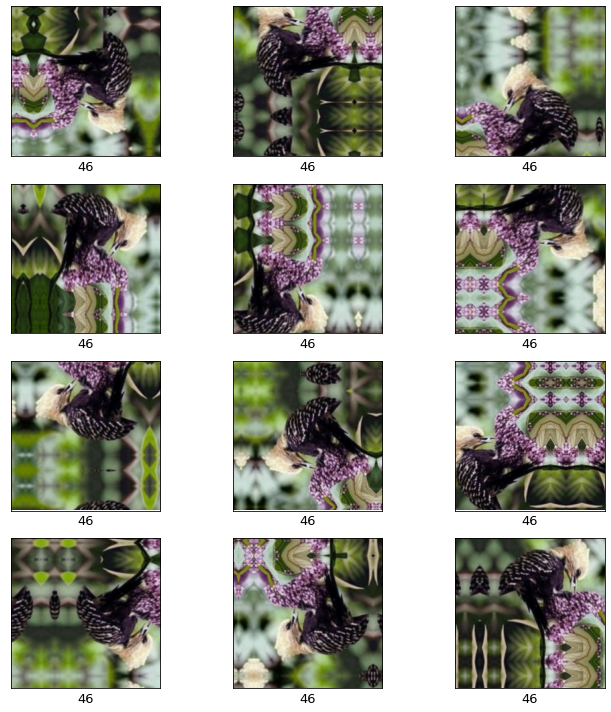

In [35]:
# image augmentation
# https://www.tensorflow.org/tutorials/images/data_augmentation

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

# example of augmented image
train_img = get_image(train_df, 'data', index)
train_label = train_df.iloc[index, :]['class_index']


train_img = tf.expand_dims(train_img, 0)

plt.figure(figsize=(10, 10))

for i in range(12):
  plt.subplot(4, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  aug_img = data_augmentation(train_img)
  plt.imshow(aug_img[0], cmap='gray')
  plt.xlabel(train_label, fontsize=13)
plt.tight_layout()    
plt.show()


## Build The Model

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet201

In [39]:
def create_model():
    target_size = (224, 224)
    img_height, img_width = target_size
    img_depth = 3
    base_model = EfficientNetB3(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(img_height, img_width, img_depth))
    inputs = Input(shape=(img_height, img_width, img_depth))
    rescale = rescale_layer(inputs)
    augmented = data_augmentation(rescale)
    resnet = base_model(augmented)
    pooling = layers.GlobalAveragePooling2D()(resnet)
    dropout = layers.Dropout(0.4)(pooling)
    outputs = Dense(len(class_names), activation="softmax")(dropout)
    model = Model(inputs=inputs, outputs=outputs)

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_8 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 310)               476470

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
              metrics=['acc'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                 patience=3, min_lr=1e-5, verbose=1)


history = model.fit(train_data_batches,
                    epochs = 60, 
                    validation_data=valid_data_batches, 
                    callbacks=[reduce_lr])